In [1]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from stable_baselines3 import PPO
import gym
import numpy as np

### New Approach

#### Train Dataset Load

In [2]:
from datasets import load_dataset

# Load a small subset (1%) of the CNN/DailyMail dataset
dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:1%]")
texts = dataset["article"]  # Extract news articles
summaries = dataset["highlights"]  # Extract summaries

print(f"Loaded {len(texts)} samples from CNN/DailyMail dataset")

Loaded 2871 samples from CNN/DailyMail dataset


In [3]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Use a lightweight model to fit into memory
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
model = GPT2LMHeadModel.from_pretrained("distilgpt2")

In [4]:
# RL Enviroment
import gym
from gym import spaces
import numpy as np
import torch

class AdaptiveContextEnv(gym.Env):
    def __init__(self, texts, summaries, model, tokenizer):
        super(AdaptiveContextEnv, self).__init__()
        self.model = model
        self.texts = texts
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.action_space = spaces.Discrete(4)  # Context lengths: [50, 100, 150, 250]
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)

    def step(self, action):
        context_lengths = [50, 100, 150, 250]
        context_length = context_lengths[action]

        # Sample a random text
        idx = np.random.randint(len(self.texts))
        text = self.texts[idx]
        ref_summary = self.summaries[idx]

        tokenized_input = self.tokenizer.encode(text, truncation=True, max_length=context_length)
        generated_summary = self.generate_summary(tokenized_input)

        # Compute ROUGE score for evaluation
        rouge_score = self.compute_rouge(generated_summary, ref_summary)

        # Efficiency reward (shorter context is better)
        efficiency = context_length / 250  # Normalize efficiency score
        reward = rouge_score * 100 + efficiency * 10  # Trade-off between task performance & efficiency

        return np.array([efficiency], dtype=np.float32), reward, True, {}

    def reset(self):
        return np.array([0.0], dtype=np.float32)

    def generate_summary(self, tokenized_input):
        """Generates a summary from the model output using max_new_tokens."""
        input_ids = torch.tensor([tokenized_input])
        attention_mask = torch.ones_like(input_ids)

        with torch.no_grad():
            output = self.model.generate(
                input_ids,
                attention_mask=attention_mask,
                max_new_tokens=50,
                num_return_sequences=1,
                pad_token_id=self.tokenizer.eos_token_id
            )

        return self.tokenizer.decode(output[0], skip_special_tokens=True)

    def compute_rouge(self, generated_summary, ref_summary):
        """Compute ROUGE-L score for summarization performance."""
        import evaluate
        rouge = evaluate.load("rouge")
        scores = rouge.compute(predictions=[generated_summary], references=[ref_summary])
    
        # If ROUGE returns a single float, return it directly
        if isinstance(scores["rougeL"], float):
            return scores["rougeL"]
        
        # Otherwise, return the F1 score
        return scores["rougeL"].fmeasure

In [5]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Wrap environment for Stable-Baselines3 PPO training
env = DummyVecEnv([lambda: AdaptiveContextEnv(texts, summaries, model, tokenizer)])

# Initialize PPO agent
agent = PPO("MlpPolicy", env, verbose=1, clip_range=0.2, max_grad_norm=0.5, device="cuda")

# Train for a small number of steps to fit into 16GB RAM
agent.learn(total_timesteps=3000)

g:\UB\RL Project\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device


g:\UB\RL Project\.venv\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 0    |
|    iterations      | 1    |
|    time_elapsed    | 3289 |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 0            |
|    iterations           | 2            |
|    time_elapsed         | 6632         |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0018539974 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 100          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00313     |
|    value_loss           | 414          |
------------------------------------------


In [6]:
# Save the model
agent.save("ppo_adaptive_context")

#### Load test dataset

In [7]:
from datasets import load_dataset

# Load test set: 50 samples from the "test" split
test_dataset = load_dataset("cnn_dailymail", "3.0.0", split="test[:50]")
test_texts = test_dataset["article"]
test_summaries = test_dataset["highlights"]

print(f"Loaded {len(test_texts)} samples from CNN/DailyMail test set")

Loaded 50 samples from CNN/DailyMail test set


In [8]:
def evaluate_agent_on_test(agent, vec_env, test_texts, test_summaries):
    context_map = [50, 100, 150, 250]
    selected_actions = []
    rouge_scores = []

    from evaluate import load
    rouge = load("rouge")

    # Unwrap actual env
    env = vec_env.envs[0]

    for i in range(len(test_texts)):
        obs = vec_env.reset()
        action, _ = agent.predict(obs)
        selected_actions.append(int(action))

        ctx_len = context_map[int(action)]
        text = test_texts[i]
        ref_summary = test_summaries[i]

        tokenized_input = env.tokenizer.encode(text, truncation=True, max_length=ctx_len)
        input_ids = torch.tensor([tokenized_input]).to(env.model.device)

        attention_mask = torch.ones_like(input_ids)

        with torch.no_grad():
            output = env.model.generate(
                input_ids,
                attention_mask=attention_mask,
                max_new_tokens=50,
                pad_token_id=env.tokenizer.eos_token_id
            )

        generated_summary = env.tokenizer.decode(output[0], skip_special_tokens=True)

        score = rouge.compute(predictions=[generated_summary], references=[ref_summary])
        rouge_l = score["rougeL"] if isinstance(score["rougeL"], float) else score["rougeL"].fmeasure
        rouge_scores.append(rouge_l)

    selected_actions = np.array(selected_actions)
    selected_contexts = np.array(context_map)[selected_actions]
    avg_rouge = np.mean(rouge_scores)
    avg_context = np.mean(selected_contexts)

    print(f"\nRL Agent Performance on Test Set:")
    print(f"Average ROUGE-L: {avg_rouge:.4f}")
    print(f"Average Selected Context Length: {avg_context:.2f}")
    return avg_rouge, avg_context, selected_contexts

In [14]:
def evaluate_fixed_contexts(model, tokenizer, test_texts, test_summaries):
    from evaluate import load
    rouge_metric = load("rouge")

    fixed_contexts = [50, 100, 150, 250]
    fixed_rouge_scores = {}

    for ctx in fixed_contexts:
        predictions = []
        references = []

        for i in range(len(test_texts)):
            text = test_texts[i]
            ref_summary = test_summaries[i]

            tokenized_input = tokenizer.encode(text, truncation=True, max_length=ctx)
            input_ids = torch.tensor([tokenized_input]).to(model.device)

            attention_mask = torch.ones_like(input_ids)

            with torch.no_grad():
                output = model.generate(
                    input_ids,
                    attention_mask=attention_mask,
                    max_new_tokens=50,
                    pad_token_id=tokenizer.eos_token_id
                )
            generated_summary = tokenizer.decode(output[0], skip_special_tokens=True)

            predictions.append(generated_summary)
            references.append(ref_summary)

        score = rouge_metric.compute(predictions=predictions, references=references)
        rouge_l = score["rougeL"] if isinstance(score["rougeL"], float) else score["rougeL"].fmeasure
        fixed_rouge_scores[ctx] = rouge_l

    print(f"\nFixed Context ROUGE-L Scores on Test Set\n")
    for key, val in fixed_rouge_scores.items():
        print(f"{key}: {val}")
    return fixed_rouge_scores

In [15]:
# Load model and tokenizer before this
fixed_scores = evaluate_fixed_contexts(model, tokenizer, test_texts, test_summaries)
agent_rouge, agent_context, agent_selected_lengths = evaluate_agent_on_test(agent, env, test_texts, test_summaries)


Fixed Context ROUGE-L Scores on Test Set

50: 0.200431346225769
100: 0.20088681432678174
150: 0.1679153997525253
250: 0.13420461487553306


C:\Users\swara\AppData\Local\Temp\ipykernel_61024\1307451381.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  selected_actions.append(int(action))
C:\Users\swara\AppData\Local\Temp\ipykernel_61024\1307451381.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ctx_len = context_map[int(action)]



RL Agent Performance on Test Set:
Average ROUGE-L: 0.1666
Average Selected Context Length: 163.00


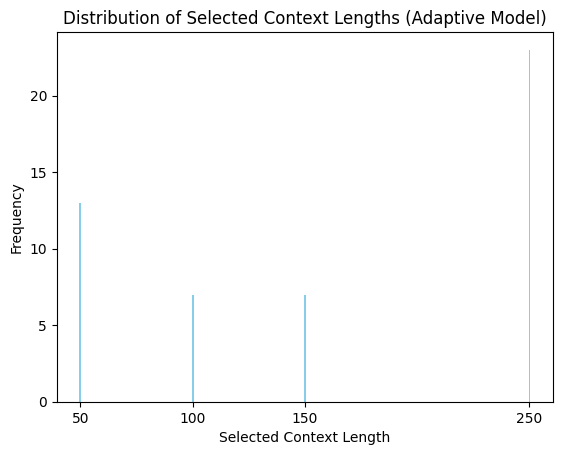

In [16]:
import matplotlib.pyplot as plt

# Count occurrences of selected context lengths
unique, counts = np.unique(agent_selected_lengths, return_counts=True)
plt.bar(unique, counts, color="skyblue")

plt.xlabel("Selected Context Length")
plt.ylabel("Frequency")
plt.title("Distribution of Selected Context Lengths (Adaptive Model)")
plt.xticks([50, 100, 150, 250])
plt.show()